In [497]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


folow this : https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

In [498]:
df = pd.read_csv('/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/tariff_war/raw_data/2025_jun30_tariffwar.csv', index_col= None)
df = df.set_index('Year')
df = df.drop(['Unnamed: 0'], axis=1)
df = df.dropna()

In [499]:
df.head()

,Hurs,pr,tas,exchange_rate,Trade_value_brazil_china,soy_production(ton),Soybean_production(h),Export_Usa_china_MT,forest_loss_PA (h),forest_loss_SC (h),natural_forest_loss (h),non_natural_forest_loss (h),soy_production(MT)
Year,,,,,,,,,,,,,
2002,76.92,1788.89,25.47,2.920363,8.234461e+08,50875594.0,1.741588e+07,4861427.0,3.143427e+06,57244.81214,592031.185471,197440.569126,4.615356e+07
2003,76.84,1794.61,25.48,3.077475,1.313073e+09,67454328.6,1.846232e+07,11112116.0,2.934752e+06,38064.14357,541378.668729,167506.642505,6.119354e+07
2004,76.82,1813.79,25.47,2.925119,1.621736e+09,63953364.1,2.001425e+07,9402546.0,3.472617e+06,53831.41993,695402.772147,205744.636884,5.801752e+07
2005,76.84,1839.55,25.46,2.434390,1.710493e+09,55670925.0,2.238304e+07,9434308.0,3.079034e+06,43682.54115,636580.799730,211778.276359,5.050381e+07
2006,76.85,1864.67,25.45,2.175327,2.428650e+09,59148978.0,2.303288e+07,10320990.0,2.479103e+06,49569.95585,611402.321942,210762.251677,5.365905e+07


In [500]:
df.index

Index([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype='int64', name='Year')

<Axes: xlabel='Year'>

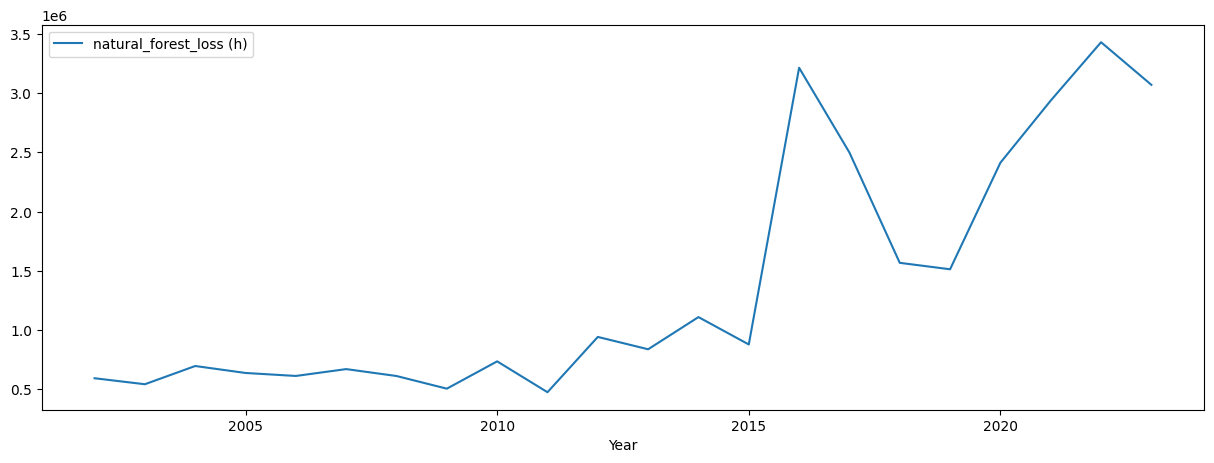

In [501]:
color_pal = sns.color_palette
df[['natural_forest_loss (h)']].plot(style = '-', figsize= (15, 5))

Train/Test Split


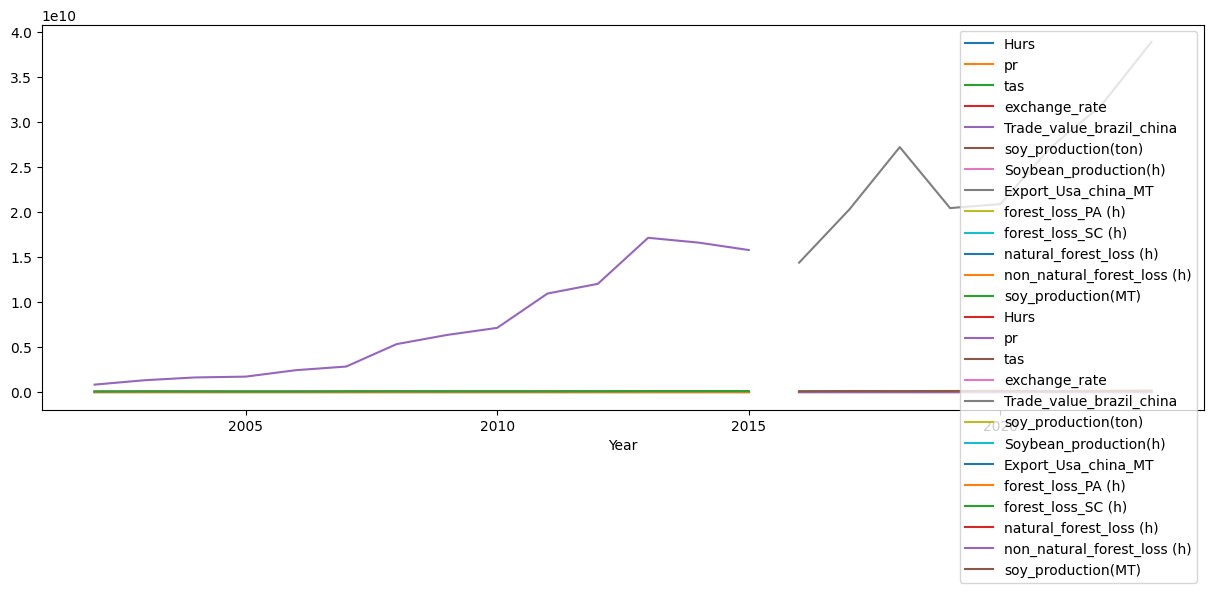

In [502]:
train = df.loc[df.index < 2016]
test = df.loc[(df.index >= 2016)]

fig, ax = plt.subplots (figsize = (15,5))
train.plot(ax=ax, label = 'Training Set')
test.plot(ax=ax, label = 'Test set')
plt.show()

In [503]:
df.columns

Index(['Hurs', 'pr', 'tas', 'exchange_rate', 'Trade_value_brazil_china',
       'soy_production(ton)', 'Soybean_production(h)', 'Export_Usa_china_MT',
       'forest_loss_PA (h)', 'forest_loss_SC (h)', 'natural_forest_loss (h)',
       'non_natural_forest_loss (h)', 'soy_production(MT)'],
      dtype='object')

In [504]:
df = df [['Hurs', 'pr', 'tas', 'exchange_rate', 'Trade_value_brazil_china',
       'soy_production(MT)', 'Soybean_production(h)', 'Export_Usa_china_MT',
       'natural_forest_loss (h)']]

In [505]:
# fig,ax = plt.subplots(figsize = (10,8))
# sns.boxplot(data =df, x= 'Year', y = 'natural_forest_loss (h)')
# plt.show()

Create Model

In [506]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score


In [507]:
features = ['Hurs', 'pr', 'tas', 'exchange_rate', 'Trade_value_brazil_china',
       'soy_production(MT)', 'Soybean_production(h)', 'Export_Usa_china_MT']
target =  'natural_forest_loss (h)'

In [508]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [509]:
from xgboost import XGBRegressor

reg = XGBRegressor(
    n_estimators=100,
    learning_rate=0.9,
    objective='reg:squarederror'
)

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

[0]	validation_0-rmse:75590.00361	validation_1-rmse:1874187.94150
[99]	validation_0-rmse:0.03423	validation_1-rmse:1840930.14014


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


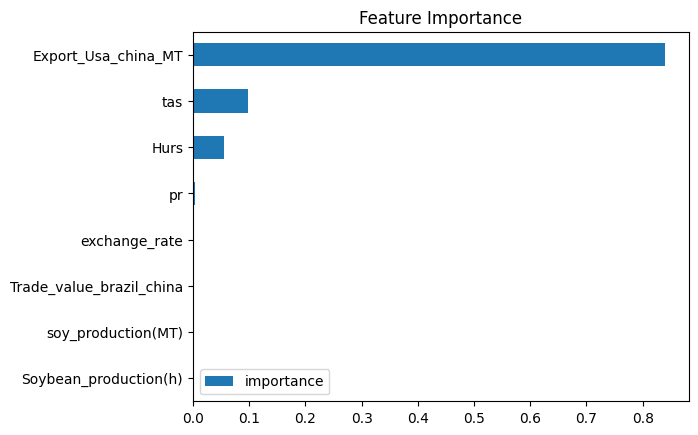

In [510]:
fi = pd.DataFrame(data= reg.feature_importances_,
                  index = reg.feature_names_in_,
                  columns = ['importance'])
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

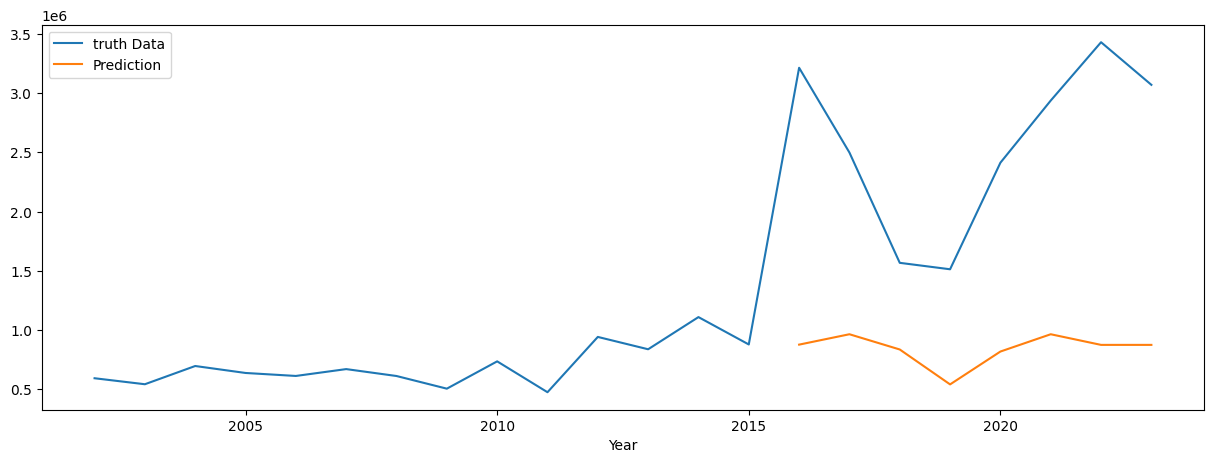

In [511]:
#forecast on Test
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how = 'left', left_index= True, right_index = True)
ax = df[['natural_forest_loss (h)']].plot(figsize= (15,5))
df['prediction'].plot(ax=ax, style = '-')
plt.legend (['truth Data', 'Prediction'])
plt.show()

In [512]:
score = np.sqrt(mean_squared_error(test['natural_forest_loss (h)'], test['prediction']))
score_r = r2_score(test['natural_forest_loss (h)'], test['prediction'])
print(f'RMSE score on Test set: {score: 0.2f}')
print(f'R squared on Test set: {score_r: 0.2f}')

RMSE score on Test set:  1840930.13
R squared on Test set: -6.34
